## Heart Disease Prediction Using Deep Learning
 
by: Al Sabay, SMU MS Datascience Graduate Research Studies

It is a common problem in medical predictive analytics that data is often small.  Additionally, privacy laws forbid the publication of this data to protect

This Deep Learning model to predict Heart Disease uses the Keras API. The dataset used is what is considered to be the "Gold Standard" in Heart Disease Prediction studies from the UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/). The "cleveland.data" file from the repository was processed through a synthesis process in order to anonymize the data (no original data appears in the data set used in this model) and also to increase the data volume to be suitable for Neural Network Models. The resulting surrogate dataset of shape 60K x 39 has the same data characteristics as the original cleveland dataset (see https://github.com/alsabay/SynthHD on how this was done).

### Initialization

In [190]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import keras_metrics
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
from keras import metrics

import matplotlib.pyplot as plt

np.random.seed(306)  # for reproducibility

# network and training
NB_EPOCH = 50
BATCH_SIZE = 512
VERBOSE = 1
NB_CLASSES = 2   # Heart Disease diagnosis yes = 1, no = 0
OPTIMIZER = Adam() # optimizer
N_HIDDEN = 1024
TRAINING_SPLIT = 0.8 # how much from all of the data is split for training
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.5



### Data Preparation

In [191]:
# read synthetic cleveland dataset from full cleveland.data
df_main = pd.read_table("data/syn_cleveland.csv", sep=',')

# Neural Net transfer function likes to work with floats
df_main.astype(float)

# Normalize values to range [0:1]
df_main /= df_main.max()

# split data into independent and dependent variables
y_all = df_main['num']
X_all = df_main.drop(columns = 'num')

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size = TRAINING_SPLIT)
Y_train = np_utils.to_categorical( y_train, NB_CLASSES) 
Y_test = np_utils.to_categorical( y_test, NB_CLASSES)

/Users/alsabay/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Neural Net Setup, Train and Validation

In [192]:
# set up the NN model
model = Sequential()
model.add(Dense(N_HIDDEN, input_shape=(38,)))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1024)              39936     
_________________________________________________________________
activation_40 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
activation_41 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 2050      
__________

In [193]:
# compile the model, optimize for recall
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

In [194]:
print(model.metrics_names) # metrics to retrieve from score after evaluation

['loss', 'acc', 'precision', 'recall']


Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 3s 85us/step - loss: 0.2962 - acc: 0.8730 - precision: 0.8730 - recall: 0.8730 - val_loss: 0.1578 - val_acc: 0.9457 - val_precision: 0.9457 - val_recall: 0.9457
Epoch 2/50
38400/38400 [==============================] - 3s 69us/step - loss: 0.1732 - acc: 0.9390 - precision: 0.9390 - recall: 0.9390 - val_loss: 0.1529 - val_acc: 0.9505 - val_precision: 0.9505 - val_recall: 0.9505
Epoch 3/50
38400/38400 [==============================] - 3s 71us/step - loss: 0.1458 - acc: 0.9508 - precision: 0.9508 - recall: 0.9508 - val_loss: 0.1157 - val_acc: 0.9648 - val_precision: 0.9648 - val_recall: 0.9648
Epoch 4/50
38400/38400 [==============================] - 3s 73us/step - loss: 0.1313 - acc: 0.9562 - precision: 0.9562 - recall: 0.9562 - val_loss: 0.1116 - val_acc: 0.9654 - val_precision: 0.9654 - val_recall: 0.9654
Epoch 5/50
38400/38400 [==============================] - 3s 77us/step - lo

38400/38400 [==============================] - 3s 83us/step - loss: 0.0842 - acc: 0.9717 - precision: 0.9717 - recall: 0.9717 - val_loss: 0.0865 - val_acc: 0.9720 - val_precision: 0.9720 - val_recall: 0.9720
Epoch 39/50
38400/38400 [==============================] - 3s 81us/step - loss: 0.0839 - acc: 0.9716 - precision: 0.9716 - recall: 0.9716 - val_loss: 0.0863 - val_acc: 0.9715 - val_precision: 0.9715 - val_recall: 0.9715
Epoch 40/50
38400/38400 [==============================] - 3s 83us/step - loss: 0.0841 - acc: 0.9726 - precision: 0.9726 - recall: 0.9726 - val_loss: 0.0849 - val_acc: 0.9721 - val_precision: 0.9721 - val_recall: 0.9721
Epoch 41/50
38400/38400 [==============================] - 3s 86us/step - loss: 0.0841 - acc: 0.9714 - precision: 0.9714 - recall: 0.9714 - val_loss: 0.0853 - val_acc: 0.9719 - val_precision: 0.9719 - val_recall: 0.9719
Epoch 42/50
38400/38400 [==============================] - 3s 89us/step - loss: 0.0848 - acc: 0.9715 - precision: 0.9715 - recall: 0

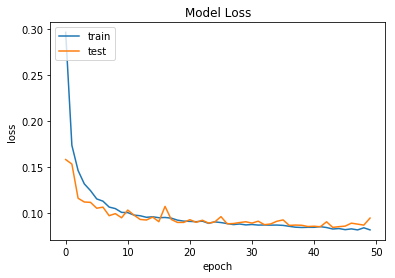

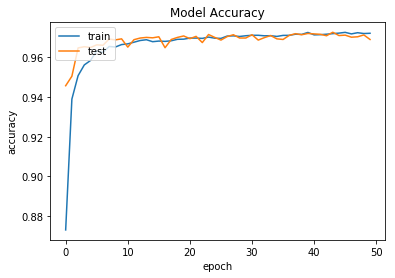

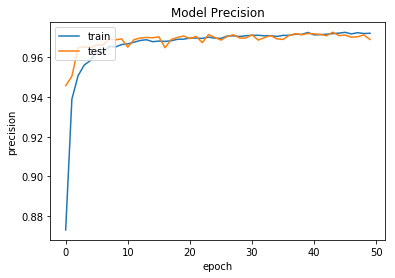

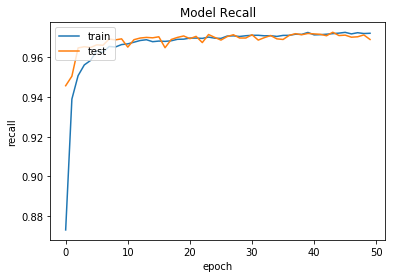

In [195]:
# train the model
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("\nTest Loss:", score[0])
print('Test Accuracy:', score[1])
print("\nTest Precision:", score[2])
print('Test Recall:', score[3])

# list all data in history
print(history.history.keys()) # dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()